# Comparison of SGD, Adam and DREM for Perceptron Learning

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, make_regression
import time

## Regression

### Dataset creation

In [147]:
def create_regression(n_features_list, n_samples=100, n_targets=1, noise=1):
    for n_features in n_features_list:
        X, y = make_regression(n_samples=n_samples,
                            n_features=n_features,
                            n_targets=n_targets,
                            noise=noise)
        data = np.c_[X, y]
        df = pd.DataFrame(data, columns=['X'+str(i) for i in range(n_features)] + ['y'])
    return df

In [148]:
n_features_list = [4]
df = create_regression(n_features_list, noise=3)
df.head()

,X0,X1,X2,X3,y
0,1.241095,-1.177530,0.444286,-1.275763,-129.762313
1,-0.605389,-0.946808,-0.232236,-0.339984,-138.101922
2,0.740434,0.699830,0.739286,-0.074342,122.344732
3,-0.946877,0.417519,-0.375982,0.418446,7.852915
4,1.701041,-0.088576,0.852175,0.100665,118.449901


In [149]:
X = np.array(df.drop(['y'], axis=1), dtype=np.float64)
y = np.array(df['y'], dtype=np.float64)
scaler = StandardScaler()
scaler.fit(X)
X_sc = scaler.transform(X)

### SGD

Create SGD from scratch for comparison

In [150]:
class LinearRegressionSGD:
    def __init__(self):
        """
        Constructor for linear regression with SGD optimizer
        """        
        self.weights = None
        self.losses = []
    
    def predict(self, X):
        return np.dot(X, self.weights) 
    
    # MSE loss for regression
    def loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    # SGD
    def fit(self, X, y, learning_rate=0.01, n_iterations=1000, batch_size=1):
        n_samples, n_features = X.shape
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.weights = np.zeros(n_features)
                
        for i in range(self.n_iterations):
            # Shuffle the data on each iteration
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # For each batch
            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_predicted = self.predict(X_batch)

                # Gradients calculation
                dw = -(2 / X_batch.shape[0]) * np.dot(X_batch.T, (y_batch - y_predicted))
                
                # Weights update
                self.weights -= self.learning_rate * dw
                            
            y_pred = self.predict(X)
            self.losses.append(self.loss(y, y_pred))

Learning time:  0.005997419357299805


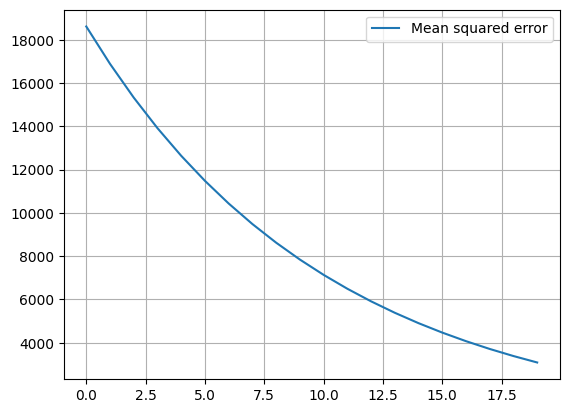

In [151]:
sgd = LinearRegressionSGD()
start_time = time.time()
sgd.fit(X_sc, y, learning_rate=0.001, n_iterations=20, batch_size=4)
end_time = time.time()
print('Learning time: ', end_time - start_time)
plt.plot(range(len(sgd.losses)), sgd.losses, label='Mean squared error')
plt.legend()
plt.grid()

### Adam

In [152]:
class LinearRegressionAdam:
    def __init__(self, beta1=0.9, beta2=0.999, epsilon=1e-8):        
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weights = None
        self.losses = []
    
    def predict(self, X):
        return np.dot(X, self.weights)
    
    def loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def fit(self, X, y, learning_rate=0.01, n_iterations=10, batch_size=4):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        n_samples, n_features = X.shape
        self.batch_size = batch_size
        self.weights = np.zeros(n_features)
        
        # Momets initialization
        m_w, v_w = np.zeros(n_features), np.zeros(n_features)
        
        for t in range(1, self.n_iterations + 1):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]            
            
                y_pred = self.predict(X_batch)
            
                # Gradients calculation
                dw = (2 / n_samples) * np.dot(X_batch.T, (y_pred - y_batch))
            
                # Moments update
                m_w = self.beta1 * m_w + (1 - self.beta1) * dw
                v_w = self.beta2 * v_w + (1 - self.beta2) * (dw ** 2)
            
                # Moments correction
                m_w_hat = m_w / (1 - self.beta1 ** t)
                v_w_hat = v_w / (1 - self.beta2 ** t)
            
                # Weights update
                self.weights -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)

            y_pred = self.predict(X)
            loss = self.loss(y, y_pred)
            self.losses.append(loss)

Learning time:  0.015998363494873047


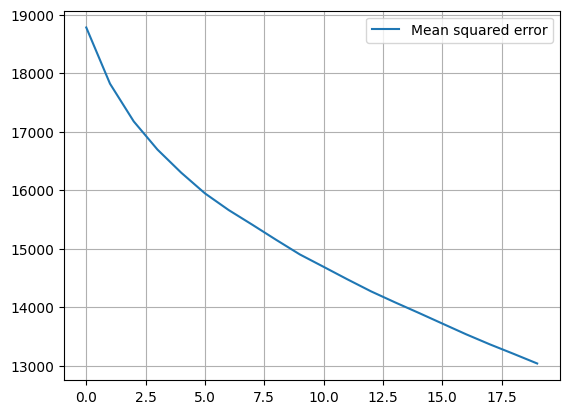

In [153]:
adam = LinearRegressionAdam()
start_time = time.time()
adam.fit(X_sc, y, learning_rate=0.1, n_iterations=20, batch_size=4)
end_time = time.time()
print('Learning time: ', end_time - start_time)
plt.plot(range(len(adam.losses)), adam.losses, label='Mean squared error')
plt.legend()
plt.grid()

### DREM

In [154]:
class LinearRegressionDREM:
    def __init__(self):
        self.batch_size = None
        self.weights = None
        self.losses = []

    def calc_mixed_y(self, X_batch, y_batch):
        y_mixed = np.zeros(len(y_batch))
        for i in np.arange(X.shape[1]):
            X_mixed = X_batch.copy()
            X_mixed[:, i] = y_batch
            y_mixed[i] = np.linalg.det(X_mixed)
        return y_mixed
    
    def predict(self, X):
        return np.dot(X, self.weights) 
    
    def loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def fit(self, X, y, learning_rate=0.001, n_iterations=100):
        n_samples, n_features = X.shape
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size =n_features
        self.weights = np.zeros(n_features)
                
        for i in range(self.n_iterations):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                delta = np.linalg.det(X_batch)
                if np.abs(delta) > 1 and np.abs(delta) < 50:
                    y_mixed = self.calc_mixed_y(X_batch, y_batch)
                    self.weights = self.weights - self.learning_rate * delta * (delta*self.weights-y_mixed) / (1 +self.learning_rate * delta**2)  
                    #self.weights = self.weights - self.learning_rate * delta * (delta*self.weights-y_mixed) 
                
            y_pred = self.predict(X)
            self.losses.append(self.loss(y, y_pred))

Learning time:  0.022998809814453125


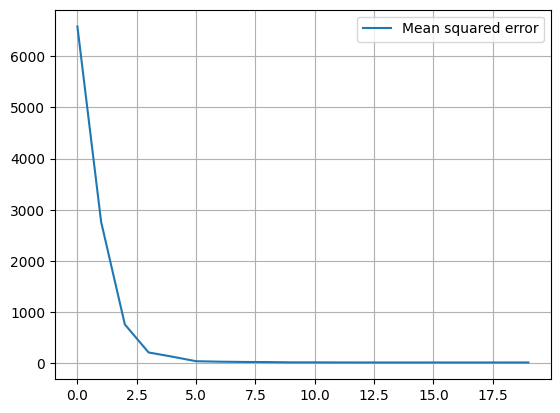

In [155]:
model = LinearRegressionDREM()
start_time = time.time()
model.fit(X_sc, y, learning_rate=0.001, n_iterations=20)
end_time = time.time()
print('Learning time: ', end_time - start_time)
plt.plot(range(len(model.losses)), model.losses, label='Mean squared error')
plt.legend()
plt.grid()
plt.show()

### Regression results comparison

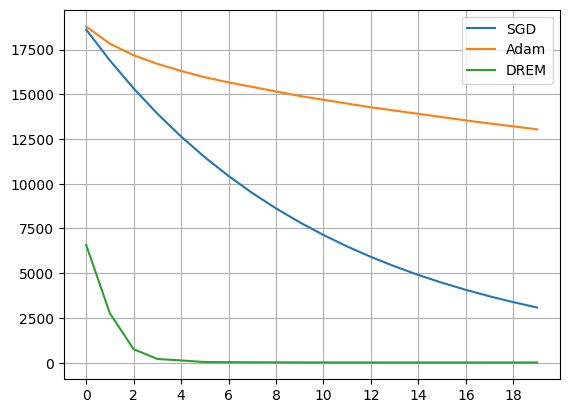

In [156]:
plt.plot(range(len(sgd.losses)), sgd.losses, label='SGD')
plt.plot(range(len(adam.losses)), adam.losses, label='Adam')
plt.plot(range(len(model.losses)), model.losses, label='DREM')
plt.legend()
plt.xticks(range(0, 20, 2))
plt.grid()

## Classification

### Loading dataset

In [157]:
X, y = load_iris(return_X_y=True)
y = np.where(y==0, 0, 1)

### SGD

In [158]:
class LogisticRegressionSGDMiniBatchNoBias:
    def __init__(self, ):
        self.weights = None
        self.losses = []
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def predict(self, X):
        return self.sigmoid(np.dot(X, self.weights))
    
    def binary_cross_entropy(self, y_true, y_pred):
        epsilon = 1e-9  
        return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
    
    def gradient(self, X, y_true, y_pred):
        return np.dot(X.T, (y_pred - y_true)) / X.shape[0]
    
    def fit(self, X, y, learning_rate=0.001, n_iterations=1000, batch_size=32):
        n_samples, n_features = X.shape
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.weights = np.zeros(n_features)  
        
        for i in range(self.n_iterations):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start in range(0, n_samples, self.batch_size):
                end = min(start + self.batch_size, n_samples)
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_pred = self.predict(X_batch)

                dw = self.gradient(X_batch, y_batch, y_pred)

                self.weights -= self.learning_rate * dw
            
            y_pred_full = self.predict(X)
            current_loss = self.binary_cross_entropy(y, y_pred_full)
            self.losses.append(current_loss)
            
    def predict_classes(self, X, threshold=0.5):
        y_pred = self.predict(X)
        return np.where(y_pred >= threshold, 1, 0)

0.027971744537353516


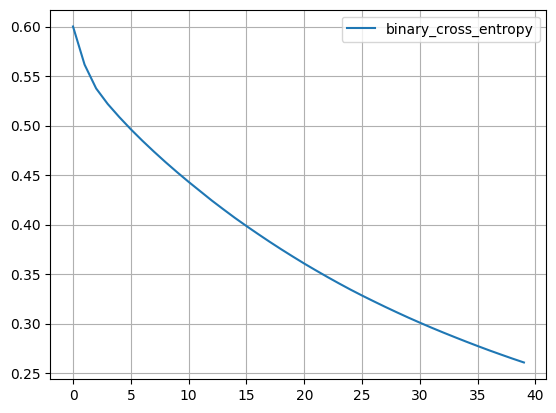

In [160]:
sgd_clf = LogisticRegressionSGDMiniBatchNoBias()  
start_time = time.time()
sgd_clf.fit(X, y, learning_rate=0.001, n_iterations=40, batch_size=4)
end_time = time.time()
print(end_time - start_time)

plt.plot(range(len(sgd_clf.losses)), sgd_clf.losses, label='binary_cross_entropy')
plt.legend()
plt.grid()

### Adam

In [163]:
class LogisticRegressionAdamNoBias:
    def __init__(self, beta1=0.9, beta2=0.999):
        self.beta1 = beta1
        self.beta2 = beta2
        self.weights = None
        self.epsilon = 1e-9
        self.losses = []
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def predict(self, X):
        return self.sigmoid(np.dot(X, self.weights))
    
    def binary_cross_entropy(self, y_true, y_pred):
        return -np.mean(y_true * np.log(y_pred + self.epsilon) + (1 - y_true) * np.log(1 - y_pred + self.epsilon))
    
    def gradient(self, X, y_true, y_pred):
        return np.dot(X.T, (y_pred - y_true)) / X.shape[0]
    
    def fit(self, X, y, learning_rate=0.001, n_iterations=1000, batch_size=32):
        n_samples, n_features = X.shape
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.weights = np.zeros(n_features)  
        
        m_w, v_w = np.zeros(n_features), np.zeros(n_features)
        
        for t in range(1, self.n_iterations + 1):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start in range(0, n_samples, self.batch_size):
                end = min(start + self.batch_size, n_samples)
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_pred = self.predict(X_batch)

                dw = self.gradient(X_batch, y_batch, y_pred)

                m_w = self.beta1 * m_w + (1 - self.beta1) * dw

                v_w = self.beta2 * v_w + (1 - self.beta2) * (dw ** 2)

                m_w_hat = m_w / (1 - self.beta1 ** t)
                v_w_hat = v_w / (1 - self.beta2 ** t)

                self.weights -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            
            pred = self.predict(X)
            current_loss = self.binary_cross_entropy(y, pred)
            self.losses.append(current_loss)
            
    def predict_classes(self, X, threshold=0.5):
        y_pred = self.predict(X)
        return np.where(y_pred >= threshold, 1, 0)

0.04799795150756836


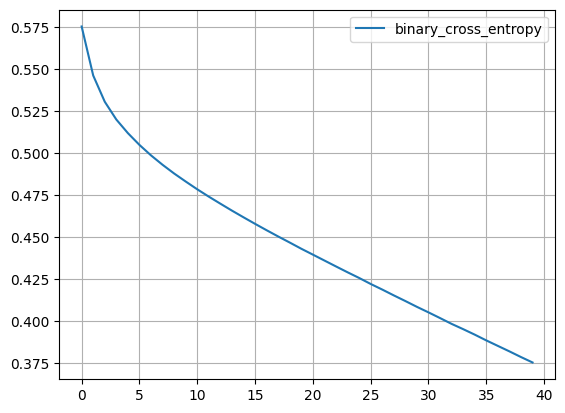

In [164]:
adam_clf = LogisticRegressionAdamNoBias()
start_time = time.time()
adam_clf.fit(X, y, learning_rate=0.001, n_iterations=40, batch_size=4)
end_time = time.time()
print(end_time - start_time)

plt.plot(range(len(adam_clf.losses)), adam_clf.losses, label='binary_cross_entropy')
plt.legend()
plt.grid()

### DREM

In [165]:
class LogisticRegressionDREMNoBias:
    def __init__(self):
        self.batch_size = None
        self.weights = None
        self.losses = []

    # Сигмоидная функция активации
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    # Бинарная кросс-энтропия
    def binary_cross_entropy(self, y_true, y_pred):
        epsilon = 1e-9  # Малое значение для предотвращения деления на ноль
        return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
    
    # Производная целевого функционала (кросс-энтропии) по весам
    def gradient(self, X, y_true, y_pred):
        return np.dot(X.T, (y_pred - y_true)) / X.shape[0]
    
    # Прямой проход (линейная модель без смещения)
    def predict(self, X):
        return self.sigmoid(np.dot(X, self.weights))
    
    def calc_mixed_y(self, X_batch, y_batch):
        y_mixed = np.zeros(len(y_batch))
        for i in np.arange(X.shape[1]):
            X_mixed = X_batch.copy()
            X_mixed[:, i] = y_batch
            y_mixed[i] = np.linalg.det(X_mixed)
        return y_mixed
    
    def fit(self, X, y, learning_rate=0.001, n_iterations=100):
        n_samples, n_features = X.shape
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = n_features
        self.weights = np.zeros(n_features)
        for i in range(self.n_iterations):
            # Перемешивание данных для каждой итерации
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Проход по батчам
            for start in range(0, n_samples - n_features, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]          

                delta = np.linalg.det(X_batch)       
                if np.abs(delta) > 1 and np.abs(delta)<50:
                    y_mixed = self.calc_mixed_y(X_batch, y_batch)                   
                    for i in range(len(self.weights)):
                        e = y_mixed[i] - self.sigmoid(delta * self.weights[i])
                       # dw = e * self.sigmoid(delta * self.weights[i]) * (1 - self.sigmoid(delta * self.weights[i])) * delta
                        dw = -1/n_samples * (self.sigmoid(delta * self.weights[i]) - y_mixed[i]) * delta
                        self.weights[i] += self.learning_rate * dw
                    
            y_pred_full = self.predict(X)
            current_loss = self.binary_cross_entropy(y, y_pred_full)
            self.losses.append(current_loss)  

0.062248945236206055


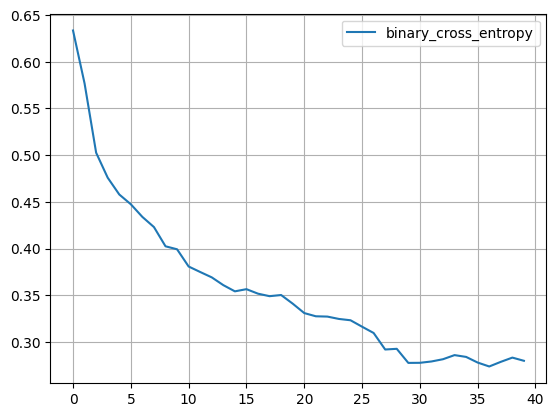

In [169]:
drem_clf = LogisticRegressionDREMNoBias() 
start_time = time.time()
drem_clf.fit(X, y, learning_rate=0.1, n_iterations=40)
end_time = time.time()
print(end_time - start_time)

plt.plot(range(len(drem_clf.losses[:40])), drem_clf.losses[:40], label='binary_cross_entropy')
plt.legend()
plt.grid()

### Classification  results comparison

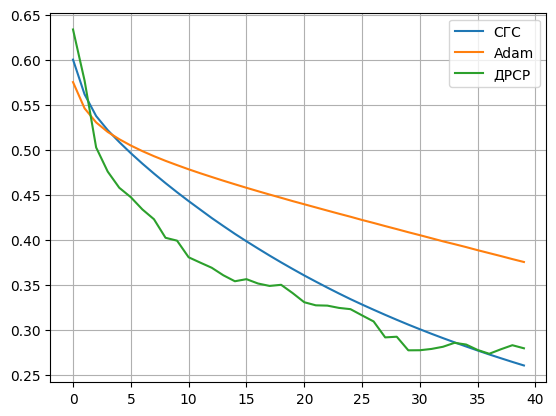

In [170]:
plt.plot(range(len(sgd_clf.losses)), sgd_clf.losses, label='СГС')
plt.plot(range(len(adam_clf.losses)), adam_clf.losses, label='Adam')
plt.plot(range(len(drem_clf.losses)), drem_clf.losses, label='ДРСР')
plt.legend()
plt.xticks(range(0, 45, 5))
plt.grid()